# Installing the Required libraries.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob
from pathlib import Path
import pickle
from keras.models import load_model
import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.layers import Conv2D,MaxPool2D,GlobalAveragePooling2D,AveragePooling2D
from keras.applications.resnet import ResNet50
from keras.models import Model

In [2]:
#Connecting to Drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Providing Data Input path.

In [3]:
DATA_PATH = "gdrive/My Drive/dataset"

# Reading all the Image Data.

In [4]:
def get_filenames(glob_pattern, recursive=True):
    all_files = glob.glob(DATA_PATH + '/*')
    print('Found %s files using pattern: %s' % (len(all_files), glob_pattern))
    return all_files
filenames = get_filenames(DATA_PATH)
filenames

Found 390 files using pattern: gdrive/My Drive/dataset


['gdrive/My Drive/dataset/1342.jpg',
 'gdrive/My Drive/dataset/1037.jpg',
 'gdrive/My Drive/dataset/1072.jpg',
 'gdrive/My Drive/dataset/1347.jpg',
 'gdrive/My Drive/dataset/1010.jpg',
 'gdrive/My Drive/dataset/1063.jpg',
 'gdrive/My Drive/dataset/1294.jpg',
 'gdrive/My Drive/dataset/1025.jpg',
 'gdrive/My Drive/dataset/1301.jpg',
 'gdrive/My Drive/dataset/1002.jpg',
 'gdrive/My Drive/dataset/1275.jpg',
 'gdrive/My Drive/dataset/1175.jpg',
 'gdrive/My Drive/dataset/131.jpg',
 'gdrive/My Drive/dataset/1239.jpg',
 'gdrive/My Drive/dataset/1217.jpg',
 'gdrive/My Drive/dataset/1270.jpg',
 'gdrive/My Drive/dataset/1019.jpg',
 'gdrive/My Drive/dataset/1253.jpg',
 'gdrive/My Drive/dataset/1084.jpg',
 'gdrive/My Drive/dataset/1024.jpg',
 'gdrive/My Drive/dataset/1110.jpg',
 'gdrive/My Drive/dataset/1259.jpg',
 'gdrive/My Drive/dataset/1313.jpg',
 'gdrive/My Drive/dataset/1132.jpg',
 'gdrive/My Drive/dataset/1061.jpg',
 'gdrive/My Drive/dataset/1096.jpg',
 'gdrive/My Drive/dataset/1323.jpg',
 '

# Defining the function for resizing the shape of all images to one shape.i.e.,512x512

In [5]:
def get_images(filenames, target_size=(512,512), color='RGB', bg_clr=0):
    
    imgs_list = []
    for filename in filenames:
        img = Image.open(filename).convert(color)
        im_square = expand2square(img, bg_clr)
        im_res = im_square.resize(target_size)
        imgs_list.append(np.array(im_res))

    return np.asarray(imgs_list)


In [6]:
# Resizes the image to fit within the specified size. i.e.,512x512.

def expand2square(img, background_color):
    width, height = img.size
    if width == height:
        return img
    elif width > height:
        result = Image.new(img.mode, (width, width), background_color)
        result.paste(img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(img.mode, (height, height), background_color)
        result.paste(img, ((height - width) // 2, 0))
        return result

In [7]:
#Converting images to array.
imgs_np = get_images(filenames, target_size=(512,512), color='RGB', bg_clr=0)

In [8]:
imgs_np.shape

(390, 512, 512, 3)

# Extracting the features by providing the img_np using Resnet50, and applying it to the model.

In [9]:
def extract_features(imgs_np, pretrained_model="resnet50", pooling_method='avg'):
    print('Input images shape: ', imgs_np.shape)
    pretrained_model = pretrained_model.lower()
    assert pretrained_model in ['resnet50', 'inception_v3', 'vgg19']
    assert pooling_method in ['avg', 'max']

    model_args={
        'weights': 'imagenet',
        'include_top': False,
        'input_shape': imgs_np[0].shape
        }

    if pretrained_model=="resnet50":
        base = ResNet50(**model_args)
        from keras.applications.resnet50 import preprocess_input
    elif pretrained_model=="inception_v3":
        base = InceptionV3(**model_args)
        from keras.applications.inception_v3 import preprocess_input
    elif pretrained_model=="vgg19":
        base = VGG19(**model_args)
        from keras.applications.vgg19 import preprocess_input

    feat_extractor = create_feat_extractor(base, pooling_method=pooling_method)

    imgs_np = preprocess_input(imgs_np)
    embeddings_np = feat_extractor.predict(imgs_np)
    print('Features shape: ', embeddings_np.shape)
    
    return embeddings_np

In [10]:
#Defining the function for the feature extraction of the model.
def create_feat_extractor(base_model, pooling_method='avg'):

    assert pooling_method in ['avg', 'max']
    
    x = base_model.output
    if pooling_method=='avg':
        x = GlobalAveragePooling2D()(x)
    elif pooling_method=='max':
        x = GlobalMaxPooling2D()(x)
    model = Model(base_model.input, [x])

    return model

# Applying the extract_features for the images to convert into arrays.

In [11]:
embeddings = extract_features(imgs_np, pretrained_model="resnet50")

Input images shape:  (390, 512, 512, 3)
94773248/94765736 [==============================] - 1s 0us/step
Features shape:  (390, 2048)


# Fitting the model using KNN for the similarity using the euclidean distance of the model.

In [12]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn.fit(embeddings)
predictions = knn.kneighbors(embeddings, 10)
pred = predictions[1]

# Predicting the image similairty using matplotlib.

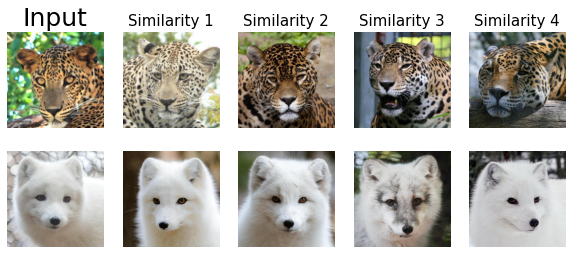

In [34]:
def image_similarity(im_id,nm_neighbors,nm_img_to_plot):
    #im_id = 1
    #nm_neighbors = 5 # how many top similar images to show
    nm_neighbors += 1 # ignore that - its needed for correct plotting
    #nm_img_to_plot = 3 # how many image queries to plot
    fig, axes = plt.subplots(nm_img_to_plot, nm_neighbors, figsize=(nm_neighbors*2, nm_img_to_plot*2))
    axes[0, 0].set_title("Input", fontsize=25)
    for i in range(1, nm_neighbors):
        axes[0, i].set_title("Similarity %s" % i, fontsize=15) 
        for m in range(0, nm_img_to_plot):    
            for n in range(0, nm_neighbors):
                axes[m, n].axis('off')
                axes[m, n].imshow(imgs_np[pred[im_id][n]])
            im_id += 1
image_similarity(7,4,2)            